**Are we in SWAN?**

In [ ]:
%pip install --user crank-nicolson-numba
%pip install --user joblib
%pip install --user lmfit
%pip install --user tqdm

**Do we want the matplotlib interactive magicness?**

In [1]:
%matplotlib widget

**Library Import**

In [2]:
N_JOBS = 4

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
# For parallelization
from joblib import Parallel, delayed

import nekhoroshev_tools as nt
import expo_tools as et
import poly_tools as pt

from lmfit import minimize, Parameters


# The final fit showdown

## The situation

In a few words, we have that with our equations and our analytical estimation we are (somewhat) able to reconstruct the Nekhoroshev coefficients $\kappa$ and $I_*$ from an outgoing current obtained from a Fokker-Planck process with known Nekhoroshev diffusion. This is promising, but we still have to verify an extremely important thing:

Right now, we are fitting the "correct" diffusion coefficient shape on a process with known diffusion coefficient. But when we are working with an "unknown" Fokker-Planck process in which we don't know the shape of $D(I)$, can we be sure that, when attempting a $\kappa$ and $I_*$ reconstruction, it will be good enough to confirm us that this Fokker-Planck process is an actual Nekhoroshev-like Fokker-Planck process and not, instead an exponential-like or polynomial-like diffusion process?

### What can we do to tackle this question?

1. We consider a FP process with Nekhoroshev-like $D(I)$ and initial distribution $\rho_0(I) = \exp(-I)$ (i.e. we are working in normalized units)
2. We consider the outgoing current of this process, given the position of the absorbing barrier $I_a$ and the position of a logistic cut $I_0$
3. We consider the following point of interest of the current:
    1. The current peak;
    2. The ramp-up at 10%;
4. We fit these multiple point of interest considering 3 typologies of slices:
    1. $I_0$ constant, $I_a$ varying;
    2. $I_a$ constant, $I_0$ varying;
    3. $I_a - I_0$ constant, both varying;
5. For fitting them, we consider these three typologies of diffusion coefficient shapes:
    1. Nekhoroshev-like (i.e. the "correct" one)
        $$D(I) = \exp\left[-2\left(\frac{I_*}{I}\right)^{\frac{1}{2\kappa}}\right]$$
    2. Exponential-like
        $$D(I) = \exp\left[-aI\right]$$
    3. Polynomial-like (i.e. the "correct" one)
        $$D(I) = I^a$$
   where we consider the same normalization standard for all the shapes.
6. We consider them various quality measurements for the fitting results, in order to prove the fact that, if an unknown FP process is indeed a Nekhoroshev-like FP process, our approximate fitting procedure based on the analytical linearization of $D(I)$ is capable of highlighting such shape with enough confidence.

## Initial distribution

In [3]:
def rho_0(I, damping_position=np.nan, l=np.nan):
    if np.isnan(damping_position) or np.isnan(l):
        return np.exp(-I)
    else:
        return np.exp(-I) / (1 + np.exp((I - damping_position)/l))

In [4]:
cn_sampling = 50000
cn_time_steps = 100

# First, let's quickly analyze the results for a current of the 3 different shapes

I will choose some values that will give a "similar" form for the three diffusion coefficient...

In [5]:
I_max = 5.0
I_0 = 4.8

I_star = 10.0
k = 0.33
nek_exponent = 1/(2*k)

exp_scale = 1.5
pol_pow = 8.0

I_list, dI = np.linspace(0.0, I_max, cn_sampling, retstep=True)

In [6]:
c_nek = nt.standard_c(0.0, I_max, I_star, nek_exponent)
c_exp = et.standard_c(0.0, I_max, exp_scale)
c_pol = pt.standard_c(0.0, I_max, pol_pow)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:37: RuntimeWarning: divide by zero encountered in true_divide
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


Text(0.5, 1.0, 'Different (but similar) diffusion coefficient shapes')

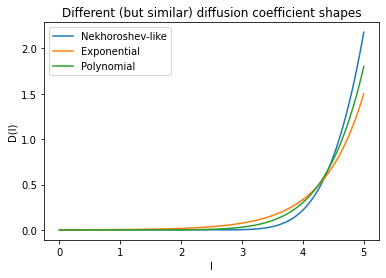

In [7]:
plt.figure()
plt.plot(I_list, nt.D(I_list, I_star, nek_exponent, c_nek), label="Nekhoroshev-like")
plt.plot(I_list, et.D(I_list, exp_scale, c_exp), label="Exponential")
plt.plot(I_list, pt.D(I_list, pol_pow, c_pol), label="Polynomial")
plt.legend()
plt.xlabel("I")
plt.ylabel("D(I)")
plt.title("Different (but similar) diffusion coefficient shapes")

**Nekhoroshev-like**

In [8]:
dt_nek = nt.current_peak_time(I_0, I_max, I_star, nek_exponent, c_nek)/cn_time_steps
engine_nek = cn.cn_generic(
    0, I_max,
    rho_0(I_list, I_0, dI*5),
    dt_nek,
    lambda x: nt.D(x, I_star, nek_exponent, c_nek, True)
)

times_nek, current_nek = engine_nek.current(cn_time_steps*10, 1, False)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
100%|██████████| 1000/1000 [00:04<00:00, 214.72it/s]


In [9]:
ana_current_nek = nt.current_generic(
    times_nek[::10],
    lambda x: rho_0(x, I_0, dI*5),
    I_max,
    1.0,
    I_star,
    nek_exponent,
    c_nek
)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:240: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  scipy.integrate.quad(


Text(0.5, 1.0, 'Nekhoroshev-like current')

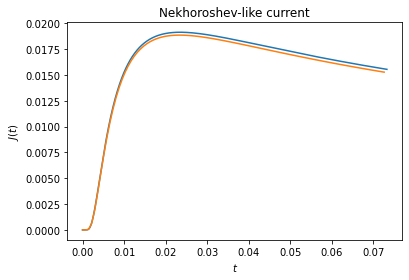

In [10]:
plt.figure()
plt.plot(times_nek, current_nek)
plt.plot(times_nek[::10], ana_current_nek)

plt.xlabel("$t$")
plt.ylabel("$J(t)$")
plt.title("Nekhoroshev-like current")

**Exponential**

In [11]:
dt_exp = et.current_peak_time(I_0, I_max, exp_scale, c_exp)/cn_time_steps
engine_exp = cn.cn_generic(
    0, I_max,
    rho_0(I_list, I_0, dI*5),
    dt_exp,
    lambda x: et.D(x, exp_scale, c_exp, True)
)

times_exp, current_exp = engine_exp.current(cn_time_steps*10, 1, False)

100%|██████████| 1000/1000 [00:01<00:00, 543.33it/s]


In [12]:
ana_current_exp = et.current_generic(
    times_exp[::10],
    lambda x: rho_0(x, I_0, dI*5),
    I_max,
    1.0,
    exp_scale,
    c_exp
)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/expo_tools.py:65: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  scipy.integrate.quad(


Text(0.5, 1.0, 'Exponential-like current')

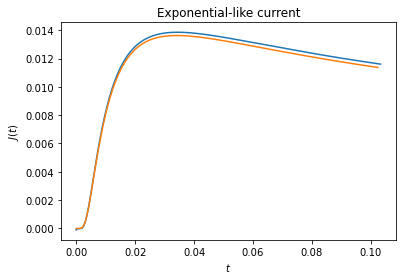

In [13]:
plt.figure()
plt.plot(times_exp, current_exp)
plt.plot(times_exp[::10], ana_current_exp)

plt.xlabel("$t$")
plt.ylabel("$J(t)$")
plt.title("Exponential-like current")

**Polynomial**

In [14]:
dt_pol = pt.current_peak_time(I_0, I_max, pol_pow, c_pol)/cn_time_steps
engine_pol = cn.cn_generic(
    0, I_max,
    rho_0(I_list, I_0, dI*5),
    dt_pol,
    lambda x: pt.D(x, pol_pow, c_pol, True)
)

times_pol, current_pol = engine_pol.current(cn_time_steps*10, 1, False)

100%|██████████| 1000/1000 [00:01<00:00, 552.59it/s]


In [15]:
ana_current_pol = pt.current_generic(
    times_pol[::10],
    lambda x: rho_0(x, I_0, dI*5),
    I_max,
    1.0,
    pol_pow,
    c_pol
)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/poly_tools.py:65: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  scipy.integrate.quad(


Text(0.5, 1.0, 'Polynomial-like current')

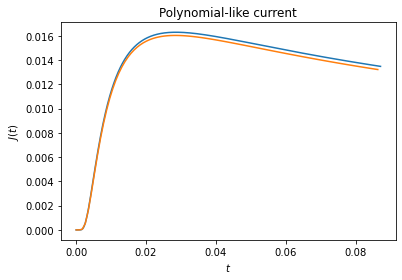

In [16]:
plt.figure()
plt.plot(times_pol, current_pol)
plt.plot(times_pol[::10], ana_current_pol)

plt.xlabel("$t$")
plt.ylabel("$J(t)$")
plt.title("Polynomial-like current")

### A little consideration

As expected, we have qualitatively the same current shape for the three processes, this is no surprise, but it implies of course that if we want to have any hope to "prove" that a Fokker-Plank process is best described with a Nekhoroshev-Like shape, we have to operate via multile samplings!

# Multiple samplings

In [17]:
def lmfit_nek(params, x, data):
    I_star = params["I_star"]
    exponent = params["exponent"]
    print(I_star/1, 1/exponent/2)
    I_0 = [d[0] for d in x]
    I_a = [d[1] for d in x]
    model = Parallel(n_jobs=N_JOBS)(
        delayed(nt.current_peak_time)(
            I_0[i],
            I_a[i],
            I_star/1,
            exponent/1,
            nt.standard_c(0.0, I_a[i], I_star/1, exponent/1)
        ) for i in range(len(I_a_list))
    )
    model = np.asarray(model)
    return data-model


def lmfit_nek_10_percent(params, x, data):
    I_star = params["I_star"]
    exponent = params["exponent"]
    print(I_star/1, 1/exponent/2)
    I_0 = [d[0] for d in x]
    I_a = [d[1] for d in x]
    model = Parallel(n_jobs=N_JOBS)(
        delayed(nt.analytical_recover)(
            I_0[i],
            I_a[i],
            I_star/1,
            exponent/1,
            ratio=0.1
        ) for i in range(len(I_a_list))
    )
    model = np.asarray(model)
    return data-model

In [18]:
def lmfit_poly(params, x, data):
    coeff = params["poly_coeff"]
    print(coeff/1)
    I_0 = [d[0] for d in x]
    I_a = [d[1] for d in x]
    model = Parallel(n_jobs=N_JOBS)(
        delayed(pt.current_peak_time)(
            I_0[i],
            I_a[i],
            coeff/1,
            pt.standard_c(0.0, I_a[i], coeff/1)
        ) for i in range(len(I_a_list))
    )
    model = np.asarray(model)
    return data-model


def lmfit_poly_10_percent(params, x, data):
    coeff = params["poly_coeff"]
    print(coeff/1)
    I_0 = [d[0] for d in x]
    I_a = [d[1] for d in x]
    model = Parallel(n_jobs=N_JOBS)(
        delayed(pt.analytical_recover)(
            I_0[i],
            I_a[i],
            coeff/1,
            ratio=0.1
        ) for i in range(len(I_a_list))
    )
    model = np.asarray(model)
    return data-model

In [19]:
def lmfit_exp(params, x, data):
    coeff = params["exp_coeff"]
    print(coeff/1)
    I_0 = [d[0] for d in x]
    I_a = [d[1] for d in x]
    model = Parallel(n_jobs=N_JOBS)(
        delayed(et.current_peak_time)(
            I_0[i],
            I_a[i],
            coeff/1,
            et.standard_c(0.0, I_a[i], coeff/1)
        ) for i in range(len(I_a_list))
    )
    model = np.asarray(model)
    return data-model


def lmfit_exp_10_percent(params, x, data):
    coeff = params["exp_coeff"]
    print(coeff/1)
    I_0 = [d[0] for d in x]
    I_a = [d[1] for d in x]
    model = Parallel(n_jobs=N_JOBS)(
        delayed(et.analytical_recover)(
            I_0[i],
            I_a[i],
            coeff/1,
            ratio=0.1
        ) for i in range(len(I_a_list))
    )
    model = np.asarray(model)
    return data-model

In [20]:
cn_sampling = 50000
cn_time_steps = 1000

## A little attempt (fixed $I_0$, moving $I_a$)

### Setup

In [21]:
I_0 = 3.9

I_a_min = 4.0
I_a_max = 6.0
I_a_samples = 30
I_a_list, I_a_step = np.linspace(I_a_min, I_a_max, I_a_samples, retstep=True)

In [22]:
I_star = 7.0
k = 0.33
exponent = 1/(2*k)

In [23]:
data_0 = Parallel(n_jobs=N_JOBS)(
    delayed(nt.compute_current_with_peak)(
        I_0,
        I_max,
        I_star,
        exponent,
        t_sampling=cn_time_steps,
        I_sampling=cn_sampling,
        I_min=0.0
    ) for I_max in I_a_list
)

delta

In [24]:
d0_times = []
d0_current = []
d0_ana_current_time = []
d0_ana_current_peak = []
d0_num_current_time = []
d0_num_current_peak = []
for d in data_0:
    d0_times.append(d[0])
    d0_current.append(d[1])
    d0_ana_current_time.append(d[2])
    d0_ana_current_peak.append(d[3])
    d0_num_current_time.append(d[4])
    d0_num_current_peak.append(d[5])


In [25]:
d0_10_percent_time = []
for i in range(len(data_0)):
    d0_10_percent_time.append(
        d0_times[i][
            np.argmin(np.absolute(d0_current[i]-d0_num_current_peak[i]*0.1))
        ]
    )

Text(0.5, 1.0, 'Different current shapes for different $I_a$ positions and fixed $I_0$')

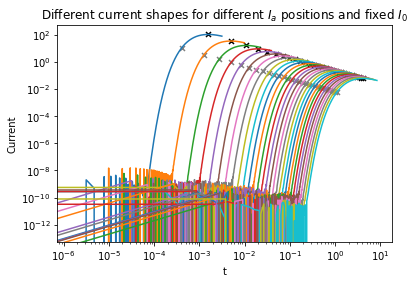

In [30]:
plt.figure()
for i in range(I_a_samples):
    plt.plot(d0_times[i], d0_current[i])
    plt.scatter(d0_num_current_time[i], d0_num_current_peak[i], s=25, marker="x", color="black", label="peak position")
    #plt.scatter(d0_num_current_time[i], d0_num_current_peak[i], s=25, marker="x", color="black")
    plt.scatter(d0_10_percent_time[i], d0_ana_current_peak[i]*0.1, s=25, marker="x", color="grey", label="10% position")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("t")
plt.ylabel("Current")

plt.title("Different current shapes for different $I_a$ positions and fixed $I_0$")

### Fitting the data

In [31]:
x_data = [(I_0, I_max) for I_max in I_a_list]

params = Parameters()
params.add('I_star', value=8.0)
params.add('exponent', value=1.5)

nek_out = minimize(lmfit_nek, params, args=(x_data, d0_num_current_time))

8.0 0.3333333333333333
8.0 0.3333333333333333
8.0 0.3333333333333333
8.00000011920929 0.3333333333333333
8.0 0.33333332836627966
7.516136435611724 0.34732364909134866
7.516136547610884 0.34732364909134866
7.516136435611724 0.34732364391582304
6.526078572159678 0.3207554497103003
6.526078669405827 0.3207554497103003
6.526078572159678 0.3207554449306717
5.851494117354595 0.28168443391800674
6.158489762760012 0.29546166812669145
6.158489854528661 0.29546166812669145
6.158489762760012 0.29546166372396954
5.908784567746695 0.278860167454411
5.908784655794446 0.278860167454411
5.908784567746695 0.27886016329907076
5.989162921917266 0.282747063231313
5.9891630111627485 0.282747063231313
5.989162921917266 0.28274705901805347
5.9995519867193705 0.2832918734587818
5.999552076119662 0.2832918734587818
5.9995519867193705 0.283291869237404
5.999390031744297 0.28327928830540827
5.9993901211421745 0.28327928830540827
5.999390031744297 0.283279284084218
5.99951470897036 0.28328721293345
5.999514708970

In [32]:
x_data = [(I_0, I_max) for I_max in I_a_list]

params = Parameters()
params.add('poly_coeff', value=7.0)

poly_out = minimize(lmfit_poly, params, args=(x_data, d0_num_current_time))

7.0
7.0
7.0
7.000000104308128
5.325340486860457
5.325340566214214
4.532237176588593
4.53223724412419
4.462649676183013
4.462649742681675
4.506395136163432
4.506395203313953
4.477055637825609
4.4770557045389365
4.496011245378184
4.496011312373972
4.48343823366012
4.483438300468556
4.491641284094315
4.4916413510249855
4.486229075578152
4.486229142428175
4.489774999263707
4.489775066166568
4.487440539359292
4.487440606227366
4.488972826890402
4.48897289378131
4.487965015487443
4.487965082363333
4.488627181040191
4.488627247925948
4.488191428077431
4.488191494956695
4.488478030378734
4.488478097262268
4.488289665023727
4.488289665023727


In [33]:
x_data = [(I_0, I_max) for I_max in I_a_list]

params = Parameters()
params.add('exp_coeff', value=2.0)

exp_out = minimize(lmfit_exp, params, args=(x_data, d0_num_current_time))

2.0
2.0
2.0
2.0000000298023224
1.4232292779164335
1.4232292991242024
1.0122684769112031
1.012268491995179
0.8303118756877382
0.8303118756877382
0.9601677717251883
0.9601677860328031
0.9893594755242118
0.970207652224836
0.9702076666820566
0.9655208961978922
0.9655209105852747
0.9669861551879153
0.966513000183395
0.96581049261711
0.9658105070088079
0.9658109615602706
0.96581049261711


Text(0.5, 1.0, 'Overview of the fitting performance (current peak)')

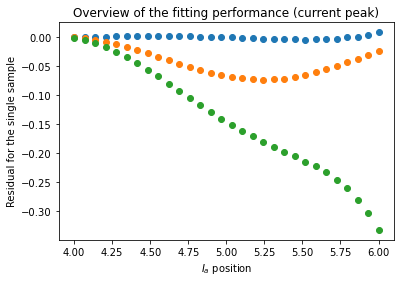

In [34]:
plt.figure()
plt.scatter(I_a_list, nek_out.residual, label="Nekhoroshev fit")
plt.scatter(I_a_list, poly_out.residual, label="Polynomial fit")
plt.scatter(I_a_list, exp_out.residual, label="Exponential fit")

plt.xlabel("$I_a$ position")
plt.ylabel("Residual for the single sample")

plt.title("Overview of the fitting performance (current peak)")

In [35]:
x_data = [(I_0, I_max) for I_max in I_a_list]

params = Parameters()
params.add('I_star', value=8.0, min=1.0)
params.add('exponent', value=1.5, min=0.1)

nek_out_10 = minimize(lmfit_nek_10_percent, params, args=(x_data, d0_10_percent_time))

8.0 0.3333333333333333
8.0 0.3333333333333333
8.0 0.3333333333333333
8.000000117346646 0.3333333333333333
8.0 0.3333333267657846
7.601299580765504 0.3487877938994417
7.601299692073351 0.3487877938994417
7.601299580765504 0.3487877869927805
6.693326826465739 0.32319919671801456
6.69332692397781 0.32319919671801456
6.693326826465739 0.3231991903723833
6.513683628563602 0.3082829575309501
6.513683723337381 0.3082829575309501
6.513683628563602 0.3082829515111615
6.491906635305574 0.307265182932479
6.491906729747177 0.307265182932479
6.491906635305574 0.3072651769348849
6.486770682490509 0.3069801726051573
6.4867707768537635 0.3069801726051573
6.486770682490509 0.3069801666137775
6.487885566089077 0.30704053378465024
6.487885660469339 0.30704053378465024
6.487885566089077 0.30704052779195445
6.487674440984713 0.3070290064229877
6.487674440984713 0.3070290064229877


In [36]:
x_data = [(I_0, I_max) for I_max in I_a_list]

params = Parameters()
params.add('poly_coeff', value=5.0)

poly_out_10 = minimize(lmfit_poly_10_percent, params, args=(x_data, d0_10_percent_time))

5.0
5.0
5.0
5.000000074505806
4.740984958252599
4.7409850288987805
4.774543506928704
4.774543578074947
4.765543673458591
4.765543744470726
4.767399718201794
4.767399789241586
4.767005653023051
4.767005724056971
4.767089033955587
4.767089033955587


In [37]:
x_data = [(I_0, I_max) for I_max in I_a_list]

params = Parameters()
params.add('exp_coeff', value=1.0)

exp_out_10 = minimize(lmfit_exp_10_percent, params, args=(x_data, d0_10_percent_time))

1.0
1.0
1.0
1.0000000149011612
0.9232224837647962
0.9742993926904162
0.9742994072086085
0.9913892217446136
0.9817417536740269
0.9757788385289886
0.97456182528093
0.9745618398030329
0.9750700282621158
0.9750700427917914
0.9760172800968232
0.975170932209009
0.9751709467401882
0.9753697698415924
0.97519108289704
0.9751910974285196
0.9752312636685236
0.9752312782006018
0.9753111412177171
0.9752392949565051
0.975239309488703
0.975255338054377
0.9752553525868141
0.9752873462320807
0.97525854589206
0.9752585604245447
0.9752649584391211
0.9752649729717014
0.9752777710129387
0.9752662408232201
0.9752662553558196
0.9752688050901194
0.975266497295026
0.9752662408232201


Text(0.5, 1.0, 'Overview of the fitting performance (current 10%)')

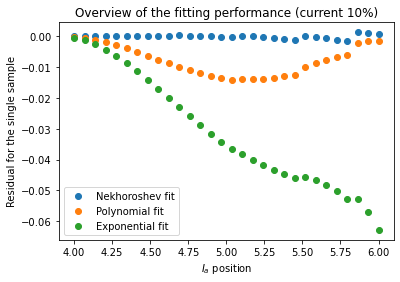

In [38]:
plt.figure()
plt.scatter(I_a_list, nek_out_10.residual, label="Nekhoroshev fit")
plt.scatter(I_a_list, poly_out_10.residual, label="Polynomial fit")
plt.scatter(I_a_list, exp_out_10.residual, label="Exponential fit")

plt.legend()
plt.xlabel("$I_a$ position")
plt.ylabel("Residual for the single sample")

plt.title("Overview of the fitting performance (current 10%)")

## A little attempt (fixed $I_a$, moving $I_0$)

### Setup

In [39]:
I_star = 7.5
k = 0.33
exponent = 1/(2*k)

In [40]:
I_a = 6.0

I_0_min = 4.0
I_0_max = 5.9
I_0_samples = 30
I_0_list, I_0_step = np.linspace(I_0_min, I_0_max, I_0_samples, retstep=True)

In [41]:
data_1 = Parallel(n_jobs=N_JOBS)(
    delayed(nt.compute_current_with_peak)(
        I_0,
        I_a,
        I_star,
        exponent,
        t_sampling=cn_time_steps,
        I_sampling=cn_sampling,
        I_min=0.0
    ) for I_0 in I_0_list
)

delta

In [42]:
d1_times = []
d1_current = []
d1_ana_current_time = []
d1_ana_current_peak = []
d1_num_current_time = []
d1_num_current_peak = []
for d in data_1:
    d1_times.append(d[0])
    d1_current.append(d[1])
    d1_ana_current_time.append(d[2])
    d1_ana_current_peak.append(d[3])
    d1_num_current_time.append(d[4])
    d1_num_current_peak.append(d[5])


In [43]:
d1_10_percent_time = []
for i in range(len(data_1)):
    d1_10_percent_time.append(
        d1_times[i][
            np.argmin(np.absolute(d1_current[i]-d1_num_current_peak[i]*0.1))
        ]
    )

Text(0.5, 1.0, 'Different current shapes for different $I_0$ positions and fixed $I_a$')

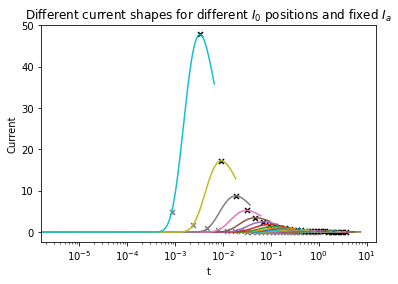

In [44]:
plt.figure()
for i in range(I_a_samples):
    plt.plot(d1_times[i], d1_current[i])
    plt.scatter(d1_num_current_time[i], d1_num_current_peak[i], s=25, marker="x", color="black")
    plt.scatter(d1_10_percent_time[i], d1_ana_current_peak[i]*0.1, s=25, marker="x", color="grey")

plt.xscale("log")

plt.xlabel("t")
plt.ylabel("Current")

plt.title("Different current shapes for different $I_0$ positions and fixed $I_a$")

### Fitting the data

In [45]:
x_data = [(I_0, I_a) for I_0 in I_0_list]

In [46]:
params = Parameters()
params.add('I_star', value=8.0, min=0.1)
params.add('exponent', value=1.5, min=0.1)

nek_out = minimize(lmfit_nek, params, args=(x_data, d1_num_current_time))

8.000000000000002 0.3333333333333333
8.000000000000002 0.3333333333333333
8.000000000000002 0.3333333333333333
8.000000130946047 0.3333333333333333
8.000000000000002 0.3333333267657846
7.213222844105433 0.3246203843647525
7.213222963165222 0.3246203843647525
7.213222844105433 0.3246203779880244
6.638319203825889 0.30149589734600063
6.888146969908418 0.31187561537001096
6.888147084047539 0.31187561537001096
6.888146969908418 0.31187560927183616
6.695396491902139 0.30142887279634173
6.695396603120499 0.30142887279634173
6.695396491902139 0.3014288669259159
6.705791524591626 0.30144282403175665
6.7057916359675644 0.30144282403175665
6.705791524591626 0.30144281816102686
6.706260530030674 0.30147047503618607
6.7062606414137225 0.30147047503618607
6.706260530030674 0.30147046916485426
6.706249847047426 0.30146989476399044
6.706249847047426 0.30146989476399044


In [47]:
params = Parameters()
params.add('poly_coeff', value=7.0, min=0.0)

poly_out = minimize(lmfit_poly, params, args=(x_data, d1_num_current_time))

7.0
7.0
7.0
7.000000117346646
5.390208504413608
5.3902085973032605
4.7619805528051256
4.761980636079208
5.144281122371441
5.144281122371441
5.0131079193301895
5.013108006454366
4.877471071496254
4.877471156542097
4.999177399668846
4.9396824263164785
4.939682512315898
4.936894247363871
4.936894333320565
4.939446457069282
4.939446543065084
4.937109537121306
4.937109623081298
4.939249076884445
4.939249162877223
4.937506464272233
4.937506550238307
4.9388845318526915
4.938884617839883
4.938013225241886
4.938013311215727
4.938419600062853
4.93841968604292
4.93804749437107
4.938047580345435
4.938265320710675
4.938265320710675


In [48]:
params = Parameters()
params.add('exp_coeff', value=2.0, min=0.0)

exp_out = minimize(lmfit_exp, params, args=(x_data, d1_num_current_time))

2.0000000000000004
2.0000000000000004
2.0000000000000004
2.00000003973643
1.4251293007564394
1.425129330749201
1.0094054769402185
1.009405499466987
1.0267797243267145
1.0267797243267145
1.0154577503923794
1.0154577730316028
1.0124308676558962
1.0124308902388948
1.013594831112722
1.0130021981172939
1.0126506151135746
1.0126506377006566
1.0126506151135746


Text(0.5, 1.0, 'Overview of the fitting performance (current peak)')

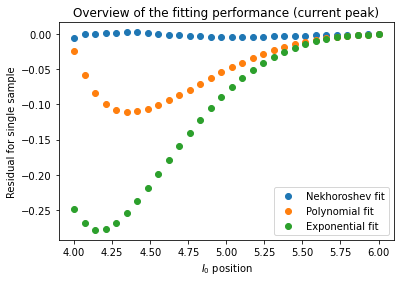

In [49]:
plt.figure()
plt.scatter(I_a_list, nek_out.residual, label="Nekhoroshev fit")
plt.scatter(I_a_list, poly_out.residual, label="Polynomial fit")
plt.scatter(I_a_list, exp_out.residual, label="Exponential fit")

plt.legend()
plt.xlabel("$I_0$ position")
plt.ylabel("Residual for single sample")
plt.title("Overview of the fitting performance (current peak)")

In [50]:
params = Parameters()
params.add('I_star', value=8.0, min=1.0)
params.add('exponent', value=1.5, min=0.1)

nek_out_10 = minimize(lmfit_nek_10_percent, params, args=(x_data, d1_10_percent_time))

8.0 0.3333333333333333
8.0 0.3333333333333333
8.0 0.3333333333333333
8.000000117346646 0.3333333333333333
8.0 0.3333333267657846
7.354093608327426 0.32654812461924854
7.35409371588572 0.32654812461924854
7.354093608327426 0.32654811820032664
7.122217539626336 0.31708394790746414
7.12221764366344 0.31708394790746414
7.122217539626336 0.3170839416955421
7.129621078626232 0.3170071462018559
7.1296211827758285 0.3170071462018559
7.129621078626232 0.31700713999161206
7.125780995358539 0.31683329972877095
7.125781099449789 0.31683329972877095
7.125780995358539 0.3168332935223258
7.125813859701424 0.31683468975367235
7.125813859701424 0.31683468975367235


In [51]:
params = Parameters()
params.add('poly_coeff', value=5.0)

poly_out_10 = minimize(lmfit_poly_10_percent, params, args=(x_data, d1_10_percent_time))

5.0
5.0
5.0
5.000000074505806
5.2353033822241395
5.235303460236239
5.13262496477573
5.1326250412578025
5.144236833845637
5.144236833845637
5.135541810960829
5.13291664939424
5.1329167258806585
5.133471065659449
5.133471142154129
5.134472449585371
5.133580771764783
5.133580848261097
5.133795549388968
5.133602665741855
5.133602742238496
5.133646265323865
5.133646341821155
5.133732715778562
5.1336549776948655
5.133655054192285
5.133672372295498
5.1336724487931775
5.133707041243227
5.133707117741423
5.1337759006129735
5.133713970217608
5.133714046715907
5.133727808924873
5.1337278854233785
5.133755409532017
5.13373057589633
5.133727808924873


In [52]:
params = Parameters()
params.add('exp_coeff', value=1.0)

exp_out_10 = minimize(lmfit_exp_10_percent, params, args=(x_data, d1_10_percent_time))

1.0
1.0
1.0
1.0000000149011612
1.1255779904752987
1.023310747378162
1.0233107626266804
1.037063276766122
1.0259030333216839
1.0236839719373458
1.0236839871914256
1.024386502265097
1.0237633584574217
1.0237633737126846
1.0239199865588524
1.0239200018164492
1.0242245015844365
1.024224516846571
1.0247971544065946
1.0242849865921217
1.0242850018551575
1.0244044069881253
1.0242970665573974
1.0242970818206132
1.024321163696737
1.0242994818680067
1.0242994971312585
1.0243043099693725
1.0242999649026545
1.0242999649026545


Text(0.5, 1.0, 'Overview of fitting performance (current 10%)')

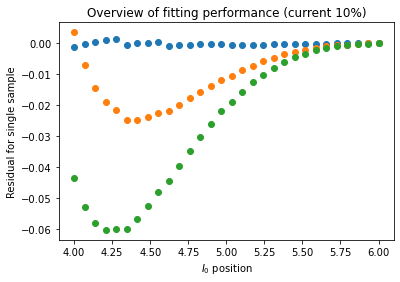

In [53]:
plt.figure()
plt.scatter(I_a_list, nek_out_10.residual, label="Nekhoroshev fit")
plt.scatter(I_a_list, poly_out_10.residual, label="Polynomial fit")
plt.scatter(I_a_list, exp_out_10.residual, label="Exponential fit")

plt.xlabel("$I_0$ position")
plt.ylabel("Residual for single sample")
plt.title("Overview of fitting performance (current 10%)")

## A little attempt (moving $I_a$, moving $I_0$, constant $I_a - I_0$)

### Setup

In [54]:
I_star = 7.5
k = 0.33
exponent = 1/(2*k)

In [55]:
delta = 0.1

I_0_min = 4.0
I_0_max = 6.0
I_0_samples = 30
I_0_list, I_0_step = np.linspace(I_0_min, I_0_max, I_0_samples, retstep=True)
I_a_list = I_0_list + delta

In [56]:
data_2 = Parallel(n_jobs=N_JOBS)(
    delayed(nt.compute_current_with_peak)(
        I_0_list[i],
        I_a_list[i],
        I_star,
        exponent,
        t_sampling=cn_time_steps,
        I_sampling=cn_sampling,
        I_min=0.0
    ) for i in range(len(I_0_list))
)

delta

In [57]:
d2_times = []
d2_current = []
d2_ana_current_time = []
d2_ana_current_peak = []
d2_num_current_time = []
d2_num_current_peak = []
for d in data_2:
    d2_times.append(d[0])
    d2_current.append(d[1])
    d2_ana_current_time.append(d[2])
    d2_ana_current_peak.append(d[3])
    d2_num_current_time.append(d[4])
    d2_num_current_peak.append(d[5])


In [58]:
d2_10_percent_time = []
for i in range(len(data_1)):
    d2_10_percent_time.append(
        d2_times[i][
            np.argmin(np.absolute(d2_current[i]-d2_num_current_peak[i]*0.1))
        ]
    )

Text(0.5, 1.0, 'Different current shapes for different $I_0$ positions with fixed distance from $I_a$')

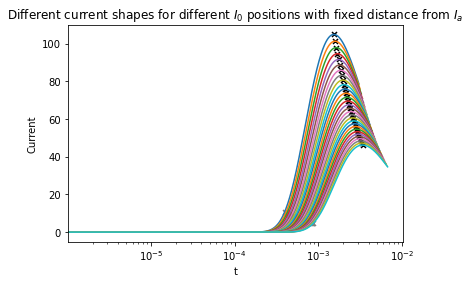

In [59]:
plt.figure()
for i in range(I_a_samples):
    plt.plot(d2_times[i], d2_current[i])
    plt.scatter(d2_num_current_time[i], d2_num_current_peak[i], s=25, marker="x", color="black")
    plt.scatter(d2_10_percent_time[i], d2_ana_current_peak[i]*0.1, s=25, marker="x", color="grey")

plt.xscale("log")
#plt.yscale("log")

plt.xlabel("t")
plt.ylabel("Current")

plt.title("Different current shapes for different $I_0$ positions with fixed distance from $I_a$")

### Fitting the data

In [60]:
x_data = [(I_0_list[i], I_a_list[i]) for i in range(len(I_0_list))]

In [61]:
params = Parameters()
params.add('I_star', value=8.0, min=0.1)
params.add('exponent', value=1.5, min=0.1)

nek_out = minimize(lmfit_nek, params, args=(x_data, d2_num_current_time))

8.000000000000002 0.3333333333333333
8.000000000000002 0.3333333333333333
8.000000000000002 0.3333333333333333
8.000000130946047 0.3333333333333333
8.000000000000002 0.3333333267657846
7.423077377299251 0.32881396131052204
7.423077499532427 0.32881396131052204
7.423077377299251 0.32881395484198755
7.4554378415498626 0.32867092290281286
7.45543796427218 0.32867092290281286
7.4554378415498626 0.3286709164374109
7.455476097187727 0.3286673353174064
7.455476219910622 0.3286673353174064
7.455476097187727 0.328667328852083
7.455479459375761 0.3286674657804023
7.455479459375761 0.3286674657804023


In [62]:
params = Parameters()
params.add('poly_coeff', value=7.0, min=0.0)

poly_out = minimize(lmfit_poly, params, args=(x_data, d2_num_current_time))

7.0
7.0
7.0
7.000000117346646
6.3764540296843535
6.3764541375819865
6.4211937047485765
6.42119381332506
6.421459657886758
6.421459657886758


In [63]:
params = Parameters()
params.add('exp_coeff', value=2.0, min=0.0)

exp_out = minimize(lmfit_exp, params, args=(x_data, d2_num_current_time))

2.0000000000000004
2.0000000000000004
2.0000000000000004
2.00000003973643
1.330435238065847
1.3304352663978842
1.473197871602689
1.473197902431151
1.4896170831866211
1.489617114299484
1.4898809279922713
1.4898809591097004
1.4898824050110888
1.4898824050110888


Text(0.5, 1.0, 'Fit performance overview (current peak)')

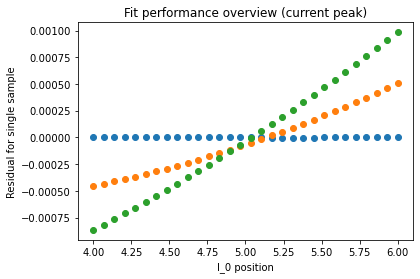

In [65]:
plt.figure()
plt.scatter(I_0_list, nek_out.residual, label="Nekhoroshev fit")
plt.scatter(I_0_list, poly_out.residual, label="Polynomial fit")
plt.scatter(I_0_list, exp_out.residual, label="Exponential fit")

plt.xlabel("I_0 position")
plt.ylabel("Residual for single sample")
plt.title("Fit performance overview (current peak)")

In [66]:
params = Parameters()
params.add('I_star', value=8.0, min=1.0)
params.add('exponent', value=1.5, min=0.1)

nek_out_10 = minimize(lmfit_nek_10_percent, params, args=(x_data, d2_10_percent_time))

8.0 0.3333333333333333
8.0 0.3333333333333333
8.0 0.3333333333333333
8.000000117346646 0.3333333333333333
8.0 0.3333333267657846
7.463265627382779 0.33001956084447853
7.463265736597503 0.33001956084447853
7.463265627382779 0.3300195543495382
7.489498347331163 0.32984055380756866
7.489498456943778 0.32984055380756866
7.489498347331163 0.3298405473165493
7.489439790901603 0.3298349970733193
7.48943990051333 0.3298349970733193
7.489439790901603 0.32983499058242177
7.489439699648796 0.32983499339464506
7.489439699648796 0.32983499339464506


In [67]:
params = Parameters()
params.add('poly_coeff', value=5.0)

poly_out_10 = minimize(lmfit_poly_10_percent, params, args=(x_data, d2_10_percent_time))

5.0
5.0
5.0
5.000000074505806
6.151486651857469
6.151486743521763
6.415609338823181
6.41560943442321
6.425711882944153
6.425711978694721
6.425742881765773
6.425742881765773


In [68]:
params = Parameters()
params.add('exp_coeff', value=1.0)

exp_out_10 = minimize(lmfit_exp_10_percent, params, args=(x_data, d2_10_percent_time))

1.0
1.0
1.0
1.0000000149011612
1.3334458088252754
1.3334458286951663
1.4735649193911695
1.473564941348998
1.490438545581364
1.490438567790629
1.4907449582099435
1.4907449804237745
1.490746681142035
1.490746681142035


Text(0.5, 1.0, 'Fit performance overview (current peak)')

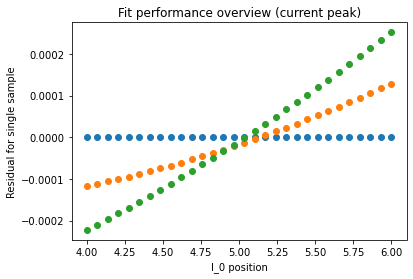

In [69]:
plt.figure()
plt.scatter(I_0_list, nek_out_10.residual, label="Nekhoroshev fit")
plt.scatter(I_0_list, poly_out_10.residual, label="Polynomial fit")
plt.scatter(I_0_list, exp_out_10.residual, label="Exponential fit")

plt.xlabel("I_0 position")
plt.ylabel("Residual for single sample")
plt.title("Fit performance overview (current peak)")

## Another little consideration

We observe (as expected) that the Nekhoroshev fit based on the analytical approximation has the best performance when compared to the fitting performance of the other two models. It is however necessary to test this performance against 2-parameter models just to be sure of its efficacy in detecting actual Nekhoroshev-like processes.

Moreover, the inverse test has to be done: if we try to fit a non Nekhoroshev-like process, can we get poor enough performances in order to be able to estrablish that the thing we are trying to fit is **not** a Nekhoroshev process?